In [269]:
import pandas as pd
import numpy as np
from solution.feature_extraction import FeatureExtraction
from solution.prediction import predict, prepare_test_df, plot_reconstruction_error
from solution.evaluation import get_fpr, get_tpr

THRESHOLD1 = 0.03612  # model.ipynb
THRESHOLD2 = 0.04612

df = pd.read_pickle("data.pkl")

In [94]:
from keras.models import load_model

autoencoder = load_model("model1")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58908 entries, 0 to 58907
Columns: 139 entries, conn_length to ssh_client_UNK
dtypes: float64(5), uint8(134)
memory usage: 9.8 MB


In [118]:
def get_labels(
    test_df: pd.DataFrame, fe_alert_df: pd.DataFrame, fe_val_df: pd.DataFrame
) -> tuple[pd.DataFrame, np.ndarray]:
    """Identify anomalies in test dataframe based on the obtain alerts."""

    # Group by source and destination IP adresses
    groups = fe_alert_df.groupby(["src_ip", "dst_ip"])
    # Extract IP adresses combinations from alert dataframe
    ip_list = [group_name for group_name, _ in groups]
    ip_set_list = [set(pair) for pair in ip_list]

    # Set mask
    mask = fe_val_df.apply(
        lambda x: set([x["src_ip"], x["dst_ip"]]) in ip_set_list, axis=1
    )

    # Label rows as anomalies
    test_df.loc[fe_val_df[mask].index, "is_anomaly"] = True

    print(
        "Number of anomalies in test data:",
        len(test_df.loc[test_df["is_anomaly"] == True]),
    )

    # Extract labels
    labels = test_df["is_anomaly"].to_numpy()

    # Return test dataframe to its original size
    test_df.drop("is_anomaly", axis=1, inplace=True)

    return test_df, labels

## TEST 1 - Replaying PCAP file
Source: https://www.malware-traffic-analysis.net/2018/06/30/index.html

Command:
```$ so-import-pcap 2018-06-30-traffic-analysis-exercise.pcap```

Elasticsearch index:
``` "so-import-2018.06.30" ```

In [ ]:
index_name = "so-import-2018.06.30"
fe = FeatureExtraction([index_name], 1000)  # "so-import-2020.09.16"

# Fetch an parse log from ES index
test_df = fe.parse_logs(get_dataset_alert=True)

# Get original dataframe (before preprocessing part)
fe_val_df = fe.get_validation_dataframe(test_df)
# Get alerts from the same index - this will be used for the test validation
fe_alert_df = fe.get_alert_dataset(test_df)

# Preprocess data
test_df = fe.preprocess_dataframe(test_df)

In [129]:
print(f"Original shape: {test_df.shape}")
test_df.head()

Original shape: (1653, 83)


,conn_length,conn_bytes_toserver,conn_bytes_toclient,http_body_length,file_size,dataset_conn,dataset_dns,dataset_file,dataset_http,dataset_smb,...,http_status_code_302.0,http_status_code_UNK,http_status_message_Found,http_status_message_Moved Permanently,http_status_message_OK,http_status_message_Partial Content,http_status_message_UNK,file_source_UNK,file_source_http,file_source_smb
0,0.000155,0.000296,0.000009,0.0,0.0,1,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0
1,0.000133,0.000266,0.000019,0.0,0.0,1,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0
2,0.000172,0.000242,0.000012,0.0,0.0,1,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0
3,0.000139,0.000249,0.000012,0.0,0.0,1,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0
4,0.000142,0.000269,0.000011,0.0,0.0,1,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0


### Alerts extraction
Three alerts in total were raised by Suricata when PCAP file was replayed.

- Rule UUID: 2010066
- Rule name: *ET POLICY Data POST to an image file (gif)*
- Rule category: *A Network Trojan was detected*
- Rule severity: *High*


In [122]:
fe_alert_df

,dataset,src_ip,src_port,dst_ip,dst_port,protocol,transport,src_country_name,dst_country_name,conn_state,...,conn_bytes_toclient,dns_query_name,dns_query_type,dns_response_code,http_request_method,http_body_length,http_status_code,http_status_message,file_size,file_source
1653,alert,172.16.2.169,49440,93.95.100.138,80,None,TCP,None,Russia,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1654,alert,172.16.2.169,49440,93.95.100.138,80,None,TCP,None,Russia,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1655,alert,172.16.2.169,49440,93.95.100.138,80,None,TCP,None,Russia,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [130]:
# Reshape test dataframe for autoencoder analysis
test_df = prepare_test_df(test_df, df)

# Add validation column - label
test_df["is_anomaly"] = False

# Get labels extracted from alert dataframe
test_df, labels = get_labels(test_df, fe_alert_df, fe_val_df)
labels

Number of anomalies in test data: 9


array([False, False, False, ..., False, False, False])

### Prediction
Threshold is set to 0.03612. This value is calculated in `model.ipynb` on normal traffic and defined in the beginning of this file.
```python
threshold = np.percentile(loss, 99)
```

52/52 [==============================] - 0s 4ms/step


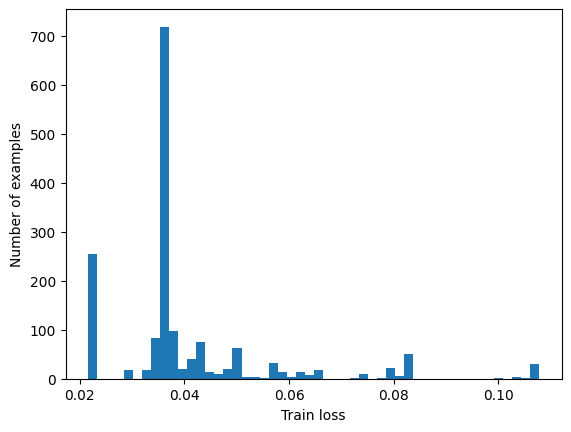

Threshold:  0.03612
Number of normal logs:  1077
Number of anomalies:  576


In [136]:
# Analyze test data using autoencoder
reconstruction_error = predict(autoencoder, test_df, plot=True)

print("Threshold: ", THRESHOLD1)
print(
    "Number of normal logs: ",
    reconstruction_error[reconstruction_error <= THRESHOLD1].size,
)
print(
    "Number of anomalies: ",
    reconstruction_error[reconstruction_error > THRESHOLD1].size,
)

In [142]:
# Get predictions based on a threshold value
preds = reconstruction_error > THRESHOLD1

# Get TPR and FPR
tpr = get_tpr(preds, labels)
fpr = get_fpr(preds, labels)

print(f"Threshold: {THRESHOLD1}\nTrue positive rate: {tpr}\nFalse positive rate: {fpr}")

Threshold: 0.03612
True positive rate: 1.0 
False positive rate: 0.3448905109489051


- In order to get better results, second threshold value is employed.

- Second threshold value (THRESHOLD2) is increased by 0.01.


In [146]:
preds = reconstruction_error > THRESHOLD2
tpr = get_tpr(preds, labels)
fpr = get_fpr(preds, labels)

print(f"Threshold: {THRESHOLD2}\nTrue positive rate: {tpr}\nFalse positive rate: {fpr}")

Threshold: 0.04612
True positive rate: 1.0
False positive rate: 0.1867396593673966


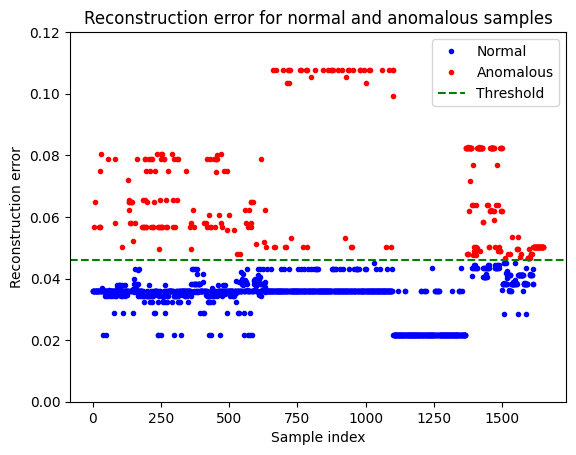

0.10784965417347857

In [155]:
# Plot reconstruction error points
plot_reconstruction_error(reconstruction_error, THRESHOLD2, (0, 0.12))

## TEST 2 - Replaying PCAP file
### QAKBOT (QBOT) INFECTION
Source: https://www.malware-traffic-analysis.net/2020/09/16/index.html

Command:
```$ so-import-pcap 2020-09-16-Qakbot-infection-traffic.pcap```

Elasticsearch index:
``` "so-import-2020.09.16" ```

In [ ]:
index_name = "so-import-2020.09.16"
fe = FeatureExtraction([index_name], 1000)

# Fetch an parse log from ES index
test_df = fe.parse_logs(get_dataset_alert=True)

# Get original dataframe (before preprocessing part)
fe_val_df = fe.get_validation_dataframe(test_df)
# Get alerts from the same index - this will be used for the test validation
fe_alert_df = fe.get_alert_dataset(test_df)

# Preprocess data
test_df = fe.preprocess_dataframe(test_df)

# Reshape test dataframe for autoencoder analysis
test_df = prepare_test_df(test_df, df)

In [255]:
test_df.shape

(184, 139)

### Alerts extraction
48 alerts in total were raised by Suricata when PCAP file was replayed.

Rules triggered by Suricata:
- ET JA3 Hash - [Abuse.ch] Possible Quakbot
- ET MALWARE Observed Qbot Style SSL Certificate
- ET INFO EXE - Served Attached HTTP
- ET JA3 Hash - [Abuse.ch] Possible Gozi
- ET MALWARE JS/WSF Downloader Dec 08 2016 M4
- ET MALWARE Likely Evil EXE download from MSXMLHTTP non-exe extension M2
- ET POLICY PE EXE or DLL Windows file download HTTP

In [185]:
print("Number of alerts: ", len(fe_alert_df))
fe_alert_df.head()

Number of alerts:  48


,dataset,src_ip,src_port,dst_ip,dst_port,protocol,transport,src_country_name,dst_country_name,conn_state,...,conn_bytes_toclient,dns_query_name,dns_query_type,dns_response_code,http_request_method,http_body_length,http_status_code,http_status_message,file_size,file_source
184,alert,108.167.180.224,80,10.9.16.101,60815,None,TCP,United States,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
185,alert,108.167.180.224,80,10.9.16.101,60815,None,TCP,United States,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
186,alert,10.9.16.101,60841,134.0.196.46,995,None,TCP,None,Oman,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187,alert,134.0.196.46,995,10.9.16.101,60832,None,TCP,Oman,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
188,alert,10.9.16.101,60833,134.0.196.46,995,None,TCP,None,Oman,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [186]:
# Add validation column - label
test_df["is_anomaly"] = False

# Get labels extracted from alert dataframe
test_df, labels = get_labels(test_df, fe_alert_df, fe_val_df)

Number of anomalies in test data: 47


### Prediction

6/6 [==============================] - 0s 4ms/step


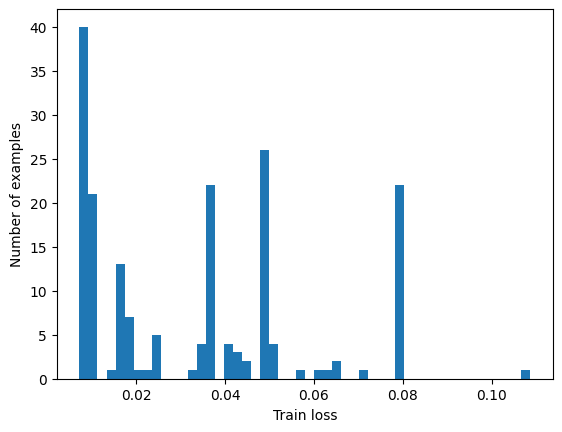

Threshold:  0.03612
Number of normal logs:  114
Number of anomalies:  70


In [187]:
# Analyze test data using autoencoder
reconstruction_error = predict(autoencoder, test_df, plot=True)

print("Threshold: ", THRESHOLD1)
print(
    "Number of normal logs: ",
    reconstruction_error[reconstruction_error <= THRESHOLD1].size,
)
print(
    "Number of anomalies: ",
    reconstruction_error[reconstruction_error > THRESHOLD1].size,
)

In [188]:
# Get predictions based on a threshold value
preds = reconstruction_error > THRESHOLD1

# Get TPR and FPR
tpr = get_tpr(preds, labels)
fpr = get_fpr(preds, labels)

print(f"Threshold: {THRESHOLD1}\nTrue positive rate: {tpr}\nFalse positive rate: {fpr}")

Threshold: 0.03612
True positive rate: 0.0425531914893617
False positive rate: 0.49635036496350365


- Qakbot detection test has poor results when predefined threshold value is utilized.
- In order to get better results, lower threshold value is employed.
- New threshold value: **0.01**.

**A lower threshold value has better results in detecting anomalies, but also increases the false positive rate.**

In [190]:
# Get predictions based on a threshold value
new_threshold = 0.01
preds = reconstruction_error > new_threshold

# Get TPR and FPR
tpr = get_tpr(preds, labels)
fpr = get_fpr(preds, labels)

print(
    f"Threshold: {new_threshold}\nTrue positive rate: {tpr}\nFalse positive rate: {fpr}"
)

Threshold: 0.01
True positive rate: 0.9787234042553191
False positive rate: 0.7153284671532847


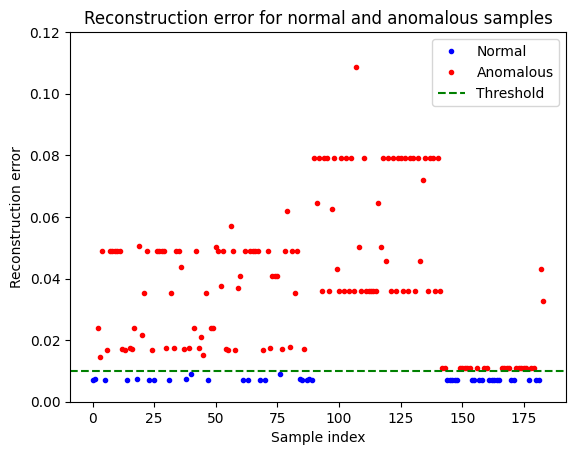

In [197]:
# Plot reconstruction error points
plot_reconstruction_error(reconstruction_error, new_threshold, (0, 0.12))

## TEST 3 - Attack launching
Attacker: Ubuntu host 100.64.192.76 (metaploit)

Target: Metasploitable VM 10.190.102.176

### SSH login brute-force attack
- Module: `auxiliary/scanner/ssh/ssh_login`
- Target port: 22
- Time: 2023-05-08 12:47

### MySQL login brute-force attack
- Module: `auxiliary/scanner/mysql/mysql_login`
- Target port: 3306
- Time: 2023-05-08 12:55

In [ ]:
fe = FeatureExtraction(["so-ids-2023.05.08"], 1000)

should_query = [
    {"term": {"source.ip": "10.190.102.176"}},
    {"term": {"destination.ip": "10.190.102.176"}},
]

test_df = fe.parse_logs(
    get_dataset_alert=True,
    additional_should_query=should_query,
)
fe_val_df = fe.get_validation_dataframe(test_df)
fe_alert_df = fe.get_alert_dataset(test_df)

fe_alerts = FeatureExtraction(["so-ids-2023.05.08"], 2000)

alert_df = fe_alerts.parse_logs(
    datasets=["alert"], additional_should_query=should_query
)

test_df = fe.preprocess_dataframe(test_df)  # Perform preprocessing

In [257]:
print(f"Original shape: {test_df.shape}")
test_df.head()

Original shape: (2047, 44)


,conn_length,conn_bytes_toserver,conn_bytes_toclient,dataset_conn,dataset_dhcp,dataset_dns,dataset_ssh,src_ip_class_src_A,src_ip_class_src_B,dst_ip_class_dst_A,...,dns_query_type_answer,dns_query_type_query,dns_response_code_REFUSED,dns_response_code_UNK,conn_state_UNK,conn_state_closed,conn_state_established,conn_state_new,ssh_client_OpenSSH_7.6p1,ssh_client_UNK
0,1.756221e-07,0.093283,0.000000,1,0,0,0,1,0,1,...,0,0,0,1,0,0,0,1,0,1
1,3.797781e-02,0.214396,0.000000,1,0,0,0,1,0,1,...,0,0,0,1,0,0,0,1,0,1
2,6.345799e-02,0.189486,0.016606,1,0,0,0,1,0,1,...,0,0,0,1,0,0,1,0,0,1
3,7.695711e-03,0.035733,0.000000,1,0,0,0,1,0,1,...,0,0,0,1,0,0,0,1,0,1
4,1.998440e-02,0.337571,0.000000,1,0,0,0,1,0,1,...,0,0,0,1,0,0,0,1,0,1


### Alerts extraction
86 alerts in total were raised by Suricata.

Rules triggered by Suricata:
- ET SCAN Suspicious inbound to mySQL port 3306
- ET SCAN Multiple MySQL Login Failures Possible Brute Force Attempt
- ET SCAN Potential SSH Scan
- ET SCAN Potential SSH Scan OUTBOUND

In [259]:
# Alerts triggered for ports 3306 (MySQL) and SSH (22)
fe_alert_df[
    fe_alert_df.src_port.isin((3306, 22)) | fe_alert_df.dst_port.isin((3306, 22))
]

,dataset,src_ip,src_port,dst_ip,dst_port,protocol,transport,src_country_name,dst_country_name,conn_state,conn_length,conn_bytes_toserver,conn_bytes_toclient,dns_query_name,dns_query_type,dns_response_code,ssh_client
2065,alert,100.64.192.76,41391.0,10.190.102.176,22.0,None,TCP,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2066,alert,100.64.192.76,41391.0,10.190.102.176,22.0,None,TCP,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2067,alert,100.64.192.76,41741.0,10.190.102.176,22.0,None,TCP,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2068,alert,100.64.192.76,38069.0,10.190.102.176,22.0,None,TCP,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2069,alert,100.64.192.76,44271.0,10.190.102.176,22.0,None,TCP,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2128,alert,10.190.102.176,3306.0,100.64.192.76,58154.0,None,TCP,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2129,alert,10.190.102.176,3306.0,100.64.192.76,38000.0,None,TCP,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2130,alert,10.190.102.176,3306.0,100.64.192.76,38018.0,None,TCP,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2131,alert,10.190.102.176,3306.0,100.64.192.76,38030.0,None,TCP,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [260]:
# Reshape test dataframe for autoencoder analysis
test_df = prepare_test_df(test_df, df)

# Add validation column - label
test_df["is_anomaly"] = False

# Get labels extracted from alert dataframe
test_df, labels = get_labels(test_df, fe_alert_df, fe_val_df)

Number of anomalies in test data: 221


### Prediction

64/64 [==============================] - 0s 4ms/step


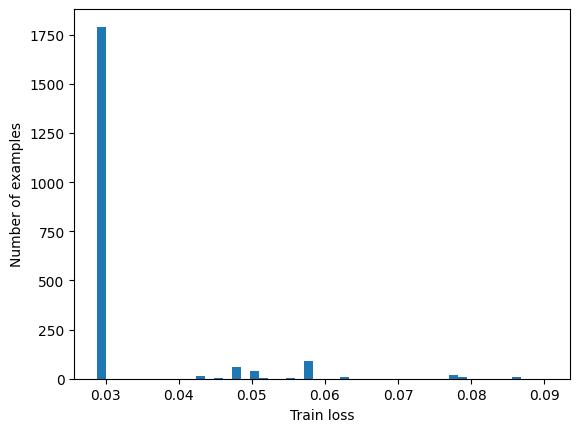

Threshold:  0.04612
Number of normal logs:  1807
Number of anomalies:  240


In [270]:
# Analyze test data using autoencoder
reconstruction_error = predict(autoencoder, test_df, plot=True)

print("Threshold: ", THRESHOLD2)
print(
    "Number of normal logs: ",
    reconstruction_error[reconstruction_error <= THRESHOLD2].size,
)
print(
    "Number of anomalies: ",
    reconstruction_error[reconstruction_error > THRESHOLD2].size,
)

In [271]:
# Get predictions based on a threshold value
preds = reconstruction_error > THRESHOLD2

# Get TPR and FPR
tpr = get_tpr(preds, labels)
fpr = get_fpr(preds, labels)

print(f"Threshold: {THRESHOLD2}\nTrue positive rate: {tpr}\nFalse positive rate: {fpr}")

Threshold: 0.04612
True positive rate: 0.9864253393665159
False positive rate: 0.012048192771084338
